### Control Parameters 

In [1]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [28]:
## parameters
exp_index = [
            'rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122',  
            'rb1_201214_123513_6ca016cb2a35d1893682c089b7e118cfe3376122',
            'rb2_201208_120334_747cb38938c76c535739e377d7ddcf7941929cb6', 
            'rb2_201214_124645_1fb28b582a0c07b1e0c355c96faae3a309a6a028',
            'rb3_201208_125205_480c461174624e388ace9ac04608f91aba1ad15c', 
            'rb3_201214_125422_23f66a6fd5be1805bf7cd07b0b1bf6655c6d6fe2',
            'rb4_201208_130611_927a9fcc88f638d5794133d62908a81779df33dd', 
            'rb4_201214_134747_ba0a89de34290b12aeac7a1962bb37d0b15bb022',
            'rb5_201208_132010_c1b0c71b7bf8e4fd28cd75e5b7e3015a2d19ed23', 
#             'rb5_201214_160837_2d7233b5a264488155044c3ef7380fa44a54c7ef', # missing several msgs
#             'rb6_201208_153458_50f011aee1008fd7935e8590229482234626fb28', # missing several msgs
            'rb8_201208_182852_e26f0b4801296bc4b9e1a98870333bf47e1925ef', 
            'rb9_201208_164241_4bc6e0115172ea94797ea0ce08fcc639b781de0a', 
            'rb10_201208_164242_f3252431ffc58f5fc6b41dcf531f159d9b5f6221', 
            'rb11_201208_164241_b03cfd1b1cf180055bc0bc2e3d0eee0e73435cbe', 
            ]

policy_xy_not_z = False
data_folder_path = './blimpReal/data/behaviour_policy'
if policy_xy_not_z: 
    SimResults_path = './blimpSim/results_XY' 
    RealResults_path = './blimpReal/results_XY' 
    mix_results_path = './blimpSim/mix_results_XY'
else:
    SimResults_path = './blimpSim/results_Z'
    RealResults_path = './blimpReal/results_Z'
    mix_results_path = './blimpSim/mix_results_Z'

name_space = 'machine_-'

class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list

Imu_msg = Msg_structure(name = name_space+'Imu',
                        feature_list = ['Time',
                                        'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                        feature_rename_list = ['Time', 
                                               'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z']
                       )
orientation_msg = Msg_structure(name = name_space+'pose',
                                feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                               'angVelocity.x','angVelocity.y','angVelocity.z',
                                               'velocity.x','velocity.y', 'velocity.z'],
                                feature_rename_list = ['Time', 'orientation.x','orientation.y','orientation.z','orientation.w',
                                                      'angVelocity.x','angVelocity.y','angVelocity.z',
                                                      'velocity.linear.x','velocity.linear.y','velocity.linear.z']
                               )
autopilotInfo_msg = Msg_structure(name = name_space+'AutopilotInfo',
                                  feature_list = ['Time','VelocityDesired.x','VelocityDesired.y','VelocityDesired.z'],
                                  feature_rename_list = ['Time','target.velocity.x','target.velocity.y','target.velocity.z']
                                 )             

transmitter_msg = Msg_structure(name = name_space+'Transmitter',
                                  feature_list = ['Time','ROSControlled','Armed','Thrust'],
                                  feature_rename_list = ['Time','ROSControlled','Armed','Thrust']
                                 )                                  
obs_msg = [
    orientation_msg,
    Imu_msg,
    autopilotInfo_msg,
    transmitter_msg,
]

actuator_command_msg = Msg_structure(name = 'actuatorcommand',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])
actuator_msg = Msg_structure(name = name_space+'actuators',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])

# act_msg = [actuator_msg, actuator_command_msg] #TODO: add act command as training data as well
act_msg = [actuator_msg]
all_msg = obs_msg + act_msg

    # *******************************************

In [29]:
## Load csv files
bool_convert_rosbag2csv = True

pseudo_target_distribution_const = 0.2
pseudo_target_min = np.array([-5.5, -5.5, -1.2])
pseudo_target_max = np.array([5.5, 5.5, 1.2])
pseudo_target_name_list = autopilotInfo_msg.feature_rename_list
pseudo_target_features_num = len(pseudo_target_name_list)-1

num_transitions = 2
assert num_transitions>=2, 'num_transitions should be greater than 2'

obs_feature_msg =  [msg.feature_rename_list for msg in obs_msg ]
act_feature_msg =  [msg.feature_rename_list for msg in act_msg ]
obs_feature_list =  list(set([item for sublist in obs_feature_msg for item in sublist]))
act_feature_list =  list(set([item for sublist in act_feature_msg for item in sublist]))

time_feature_name = 'Time'
purge_feature_list=['ROSControlled','Armed','Thrust', 'unused0','unused1','unused2','unused3']
purge_feature_list.append(time_feature_name)

merge_feature = [time_feature_name]
merge_feature = merge_feature.append(act_feature_list)

## Data processing
round_time = 1

obs_filter_feature = [item for sublist in obs_feature_msg for item in sublist if item is not time_feature_name]
act_filter_feature = ['m2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3']
train_test_split_ratio = (0.99,0.01)
act_scale_bnd = {'act_max':2000,
                 'act_min':1000,
                 'scaled_act_max':1,
                 'scaled_act_min':-1}

bool_addNoise = True ##
num_noise_df = 5
noise_level = 0.05

bool_round = False
rounding_factor = 3

## Define Reward Function
target_feature_list = ['target.velocity.x', 'target.velocity.y', 'target.velocity.z'] 
obsCost_feature_list = ['velocity.linear.x','velocity.linear.y', 'velocity.linear.z']
xy_target_feature_list = target_feature_list[0:1]
xy_cost_feature_list = obsCost_feature_list[0:1]
z_target_feature_list = target_feature_list[2]
z_cost_feature_list = obsCost_feature_list[2]
actCost_feature_list = ['m0','m1','m2']
actChangeCost_feature_list = ['m0','m1','m2','stick','tfin','bfin','lfin','rfin']

weight_next_obs = 1
weight_prev_obs = 0 * 1/(num_transitions-1)
weight_prev_act = 0 * 1/(num_transitions-1)
weight_prev_actChange = 0 * 1/(num_transitions-1)
reward_weights = (weight_next_obs, weight_prev_obs, weight_prev_act, weight_prev_actChange) 

if policy_xy_not_z:
    weight_xy_obs, weigth_z_obs = 1, 0 
else:
    weight_xy_obs, weigth_z_obs = 0, 1 
obs_reward_weights = (weight_xy_obs,weigth_z_obs)

## Create parameter dics
params = {
    "exp_index":exp_index,
    "data_folder_path":data_folder_path,
    "RealResults_path":RealResults_path,
    "SimResults_path":SimResults_path,
    "mix_results_path":mix_results_path,
    "bool_convert_rosbag2csv":bool_convert_rosbag2csv,
    
    "all_msg":all_msg,
    "obs_msg":obs_msg,    
    "act_msg":act_msg,

    "pseudo_target_name_list":pseudo_target_name_list,
    "pseudo_target_distribution_const":pseudo_target_distribution_const,
    "pseudo_target_features_num":pseudo_target_features_num,
    "pseudo_target_min":pseudo_target_min,
    "pseudo_target_max":pseudo_target_max,
    
    "num_transitions":num_transitions,
    "target_feature_list":target_feature_list,
    "xy_target_feature_list":xy_target_feature_list,
    "z_target_feature_list":z_target_feature_list,
    "obs_feature_list":obs_feature_list,
    "act_feature_list":act_feature_list,
    "time_feature_name":time_feature_name,
    "purge_feature_list":purge_feature_list,
    
    "round_time":round_time,
    
    "act_filter_feature":act_filter_feature,
    "obs_filter_feature":obs_filter_feature,
    "train_test_split_ratio":train_test_split_ratio,
    'act_scale_bnd':act_scale_bnd,
    "bool_addNoise":bool_addNoise,
    "num_noise_df":num_noise_df,
    "noise_level":noise_level,
    "bool_round":bool_round,
    "rounding_factor":rounding_factor,
    
    "obsCost_feature_list":obsCost_feature_list,
    "xy_cost_feature_list":xy_cost_feature_list,
    "z_cost_feature_list":z_cost_feature_list,
    "actCost_feature_list":actCost_feature_list,
    "actChangeCost_feature_list":actChangeCost_feature_list,
    "reward_weights":reward_weights,
    "obs_reward_weights":obs_reward_weights,
    
}

### Convert rosbag to csv

In [4]:
if params["bool_convert_rosbag2csv"]:    
    import bagpy
    from bagpy import bagreader
    from pathlib import Path
    
    class ConvertBag2csv: 
        def __init__(self):
            pass

        def rosbag2csv(self,rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self,directory):
            for root,dirs,files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        try:
                            bag_path = os.path.join(root,file)
                            file_path = os.path.splitext(bag_path)[0]
                            if not os.path.exists(file_path):
                                print(f'bag: start convert {file} ...')
                                self.rosbag2csv(bag_path)
                            else: 
                                print(f'bag: {file} already converted')
                        except:
                            print(f'bag: not able to convert {file}, skip...')
                            pass
        
    print(f'data_folder_path: {data_folder_path}')
    clsConvertBag2csv = ConvertBag2csv()
    
    print(f'----------Start Converting Rosbag to CSV files----------')
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print(f'----------Finish Convert----------')

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


data_folder_path: ./blimpReal/data/behaviour_policy
----------Start Converting Rosbag to CSV files----------
bag: rb4_201208_130611_927a9fcc88f638d5794133d62908a81779df33dd.bag already converted
bag: rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122.bag already converted
bag: rb9_201208_164241_4bc6e0115172ea94797ea0ce08fcc639b781de0a.bag already converted
bag: rb11_201208_164241_b03cfd1b1cf180055bc0bc2e3d0eee0e73435cbe.bag already converted
bag: rb1_201214_123513_6ca016cb2a35d1893682c089b7e118cfe3376122.bag already converted
bag: rb8_201208_182852_e26f0b4801296bc4b9e1a98870333bf47e1925ef.bag already converted
bag: rb4_201214_134747_ba0a89de34290b12aeac7a1962bb37d0b15bb022.bag already converted
bag: rb5_201214_160837_2d7233b5a264488155044c3ef7380fa44a54c7ef.bag already converted
bag: rb3_201208_125205_480c461174624e388ace9ac04608f91aba1ad15c.bag already converted
bag: rb10_201208_164242_f3252431ffc58f5fc6b41dcf531f159d9b5f6221.bag already converted
bag: rb2_201208_120334_747cb3

### Load data from csv files

In [5]:
class objTransitions:
    def __init__(self, df=None, num_transitions=2, 
                 act_filter_feature=[], obs_filter_feature=[], 
                 purge_feature_list=['Time'], time_feature_name=['Time'], 
                 **kwargs):
        self.df = df
        self.num_transitions = num_transitions
        assert self.num_transitions >= 2
        
        self.act_filter_feature = act_filter_feature
        self.obs_filter_feature = obs_filter_feature
        self.purge_feature_list = purge_feature_list
        self.time_feature_name = time_feature_name

        self.time = None
        self.act_trans_list = []
        self.obs_trans_list = []
        
        if (df is not None): 
            self._update()
        
    def _update(self):
        self.df_len = len(self.df.index)
        self.trans_len = len(self.df.index) - self.num_transitions
        self.time = self.get_time()
        self.act_trans_list, self.obs_trans_list = self._split_df(self.df)
        self._reset_index()
    
    def _calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs
    
    def _split_df(self,df):
        act_trans_list, obs_trans_list = [], []
        for i in range(self.num_transitions):
            act_obs_trans = df[i:self.df_len-self.num_transitions+1+i]
            act_obs_trans.reset_index(drop=True)
            act_trans, obs_trans = act_obs_trans[self.act_filter_feature], act_obs_trans[self.obs_filter_feature]
            act_trans, obs_trans = self._purge_feature(act_trans), self._purge_feature(obs_trans)
            act_trans_list.append(act_trans)
            obs_trans_list.append(obs_trans)
        return act_trans_list, obs_trans_list

    def _purge_feature(self, df):
        for feature in self.purge_feature_list:
            try:
                df=df.drop(feature, axis=1)
            except:
                pass
        return df
       
    def _reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        for i in range(self.num_transitions):
            self.act_trans_list[i].reset_index(drop=True, inplace=True)
            self.obs_trans_list[i].reset_index(drop=True, inplace=True)
    
    def get_next_transitions(self):
        next_act, next_obs = self.act_trans_list[self.num_transitions-1], self.obs_trans_list[self.num_transitions-1]
        return next_act, next_obs
    
    def get_cur_transitions(self):
        act, obs = self.act_trans_list[self.num_transitions-2], self.obs_trans_list[self.num_transitions-2]
        return act, obs
    
    def get_prev_transitions_list(self):
        prev_act_df_list, prev_obs_df_list = self.act_trans_list[:self.num_transitions-1], self.obs_trans_list[:self.num_transitions-1]
        return prev_act_df_list, prev_obs_df_list
    
    def get_delta_obs_transitions(self):
        _, next_obs = self.get_next_transitions()
        _, cur_obs = self.get_cur_transitions()
        delta_obs = self._calculate_delta_obs(cur_obs, next_obs)
        return delta_obs
    
    def get_time(self):
        return self.df[self.time_feature_name]


In [6]:
class Load_data:
    def __init__(self):
        pass

    def load_csv_index(self, directory):
        csv_index=[]
        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root,file)
                    csv_index.append(path)
        return csv_index
    
    # *******************************************
    
    def create_df_from_csvIndex(self, csv_index, **params):
        df_list = self.read_csvfiles(csv_index, **params)
        df = self.merge_df_list(df_list, merge_feature)
        df = df.sort_values(by='Time', ignore_index = True)
        return df
    
    def read_csvfiles(self, csv_index, **params):
        df_list=[]
        for msg in all_msg:
            print('[ Load Data ] read_csvfiles: ',msg.name)
            if (msg.name=="AutopilotInfo") and self.csv_not_exist(csv_index, msg.name):
                print("[ Load Data ] read_csvfiles, AutopilotInfo doesn't exist, generating...")
                time_df = df['Time']
                df = self.generate_fake_AutopilotInfo(time_df, **params)
                df_list.append(df)   
                
            elif (msg.name=="actuatorcommand") and self.csv_not_exist(csv_index, msg.name):
                print("[ Load Data ] read_csvfiles, actuatorcommand.csv does not exist, skip...")
                
            else:
                df = self.create_df(csv_index, 
                                    msg.name, 
                                    msg.feature_list, 
                                    msg.feature_rename_list,
                                    **params)
                df_list.append(df)    
        return df_list
    
    def create_df(self, csv_index, msg_name, feature_list, feature_rename_list, **params):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, **params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df    
    
    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, **params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                print(csv_name)
                df = pd.read_csv(csv_name)
        return df
    
    def merge_df_list(self, df_list, merge_feature):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how='outer', on=merge_feature)
        return df
    
    # *******************************************
    
    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)
            
            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)
                
        return df
            
    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)
        
        if data_type == str:
            col = col.map(lambda x:eval(x))
            first_element = col[0]
            data_type = type(first_element)
        
        return data_type
    
    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x:eval(x))
        
        first_element = tuple_col[0]
        feature_len = len(first_element)
        
        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)
            
        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)
        
        return df
    
    # *******************************************
    
    def csv_not_exist(self, csv_index, msg_name):
        l = [csv_name for csv_name in csv_index if msg_name in csv_name]
        if (len(l) == 0):
            return True
        else:
            return False
            
    def generate_fake_AutopilotInfo(self, time_df, **params):
        time_len = len(time_df.index)
        pseudo_target_shape = (time_len, pseudo_target_features_num)
        pseudo_target_df = self.generate_pseudo_target(pseudo_target_shape, **params)
        df = pd.concat([time_df, pseudo_target_df], axis=1)
        df.columns = pseudo_target_name_list
        return df
    
    def generate_pseudo_target(self, pseudo_target_shape, **params):
        target_noise = pseudo_target_distribution_const * np.random.normal(pseudo_target_min, pseudo_target_max, pseudo_target_shape)
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    # *******************************************
    
    def clean_df(self, df, act_filter_feature, act_scale_bnd, round_time, **params):
        df = self.fill_df_NA(df)
        df = self.clean_act_bnd_error(df, act_scale_bnd, act_filter_feature)
        df = self.clean_time_sequence(df, round_time)
        return df
        
    def fill_df_NA(self, df):
        df = df.fillna(method='ffill')
        df = df.fillna(0)
        return df
    
    def clean_act_bnd_error(self, df, act_scale_bnd, act_filter_feature):
        df = self.clip_df(df, act_scale_bnd['act_min'], act_scale_bnd['act_max'], act_filter_feature)
        return df
    
    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[ df[filter_feature] >= df_min ]
            df = df[ df[filter_feature] <= df_max ]
        df.reset_index(drop=True, inplace=True)
        return df
    
    def clean_time_sequence(self, df, round_time=1):
        time = df['Time']
        time = time.round(round_time)
        time = time.drop_duplicates()
        df = df.loc[time.index]
        return df
    
    # *******************************************
    
    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df
    
    # *******************************************

    def main(self, **params):
        df = None

        for exp in exp_index: 
            exp_path = os.path.join(data_folder_path, exp)

            print('[ LOAD csv ]', exp)
            csv_index = self.load_csv_index(exp_path)
            
            print('[ CREATE df ] start',csv_index)
            new_df = self.create_df_from_csvIndex(csv_index, **params)
            
            print('[ Clean df ] start')
            new_df = self.clean_df(new_df, **params)
            
            print('[ CONCAT df ] start')
            df = self.concat_df(df, new_df)

        print('[ Create Transitions ] Start')
        objTrans = objTransitions(df, **params)
        
        print('[ LOAD csv ] Complete')
        return objTrans

In [7]:
clsLoadData = Load_data()
objTrans = clsLoadData.main(**params)


[ LOAD csv ] rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122
[ CREATE df ] start ['./blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-gyrobias.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-Octocopter.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-TransmitterInfo.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-octoPose.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-AutopilotInfo.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/machine_-Imu.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122/rosout_agg.csv', './blimpReal/data/behaviour_policy/rb1_201208_113634_6ca016cb2a35d1893682c089b7

array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'m0'}>, <AxesSubplot:>]],
      dtype=object)

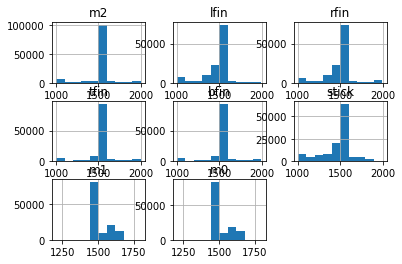

In [8]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'orientation.x'}>,
        <AxesSubplot:title={'center':'orientation.y'}>,
        <AxesSubplot:title={'center':'orientation.z'}>,
        <AxesSubplot:title={'center':'orientation.w'}>],
       [<AxesSubplot:title={'center':'angVelocity.x'}>,
        <AxesSubplot:title={'center':'angVelocity.y'}>,
        <AxesSubplot:title={'center':'angVelocity.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>],
       [<AxesSubplot:title={'center':'velocity.linear.y'}>,
        <AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'linear_acceleration.x'}>,
        <AxesSubplot:title={'center':'linear_acceleration.y'}>],
       [<AxesSubplot:title={'center':'linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>]], dtype=object)

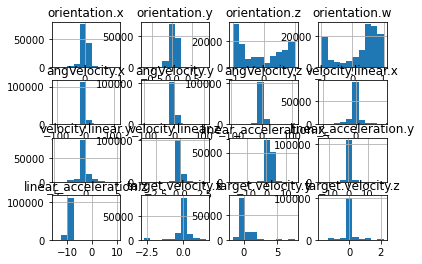

In [9]:
cur_obs.hist()

<AxesSubplot:>

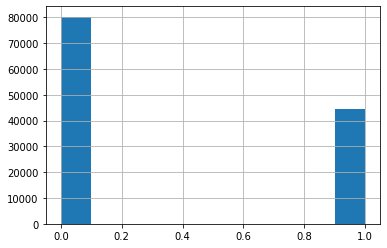

In [10]:
df = objTrans.df
df.Armed.hist()

### Data processing

In [30]:
class RealData_Processing:
    def __init__(self):
        pass
           
    def compute_flight_df(self, df):
        time, armed, thrust = df["Time"], df["Armed"],  df["Thrust"]
        
        arm_start_time, arm_stop_time = self.get_arm_start_end_time(armed, time)
        flight_start_time, flight_stop_time = self.get_flight_time(time, thrust, arm_start_time, arm_stop_time)
        flight_df = self.get_flight_df(df, time, flight_start_time, flight_stop_time)
        
        return flight_df
        
    def get_arm_start_end_time(self, armed, time):
        armedValue = armed[armed.isna() != 1]
        tArmedValue = time[armed.isna() !=1]
        
        ta_np = tArmedValue.to_numpy()
        av_np = armedValue.to_numpy()
        
        gav_np = np.gradient(av_np)
        idxStart = np.where(gav_np > 0)
        idxStop = np.where(gav_np < 0)
        
        tArmedStart = ta_np[idxStart]
        tArmedStop = ta_np[idxStop]
        
        tArmedStart = tArmedStart[range(0, len(tArmedStart), 2)]
        tArmedStop = tArmedStop[range(0, len(tArmedStop), 2)]
            
        if tArmedStart.shape[0]>tArmedStop.shape[0]:
            tArmedStop = np.append(tArmedStop, ta_np[-1])
            
        return tArmedStart, tArmedStop
    
    def get_flight_time(self, time, thrust, tArmedStart, tArmedStop, thrustThreshold=0.15, tDeltaThrust=10, tDeltaDisarm=15):
        '''
        - thrust_thresh: Thrust threshold. Flight is considered to be started when vehicel is 
                    armed and for the first time the thrust is higher than threshold value
        - time_deltaThrust_thresh: Time delta added to time point where vehicle is armed and 
                    thrust value crosses threshold. During take off vehicle usually is pushed 
                    around by helpers, that is why this time delta is necessary to exclude the 
                    take off phase from the data
        - time_deltaDisarm: Since vehicle is disarmed in advance of a crash or a landing or at 
                    least shortly after, tDeltaDisarm  is subtracted from the time point when 
                    disarming takes place. That way it is made sure that only flight data is considered
        '''

        tFlightStart, tFlightStop = [], []
        for i in range(len(tArmedStart)):
            tArmedStartTemp = tArmedStart[i]
            tArmedStopTemp = tArmedStop[i]

            thrustTemp = thrust[(time > tArmedStartTemp) & (time < tArmedStopTemp)]
            tThrustTemp = time[(time > tArmedStartTemp) & (time < tArmedStopTemp)]

            if thrustTemp[thrustTemp > thrustThreshold].empty: continue

            idxThrustThreshold =thrustTemp[thrustTemp > thrustThreshold].index[0]
            tFlightStartTemp = tThrustTemp[idxThrustThreshold] + tDeltaThrust
            tFlightStopTemp = tArmedStopTemp - tDeltaDisarm

            tFlightStart.append(tFlightStartTemp)
            tFlightStop.append(tFlightStopTemp)
        
        return tFlightStart, tFlightStop
        
    def get_flight_df(self, df, time, tFlightStart, tFlightStop):
        dfFlightList = []
        dfFlight = []
        for i in range(len(tFlightStart)):
            dfTemp = df[(time > tFlightStart[i]) & (time < tFlightStop[i])]
            dfFlightList.append(dfTemp)
            dfFlight = pd.concat(dfFlightList,ignore_index = True)
        return dfFlight
    
    def main(self, objTrans, **params):
        df = self.compute_flight_df(objTrans.df)
        objTrans = objTransitions(df, **params)
        return objTrans
        

In [31]:
clsRealDataProcessing = RealData_Processing()
objTrans_flightTime = clsRealDataProcessing.main(objTrans)


In [32]:
class Data_processing:
    def __init__(self):
        pass
            
    def data_processsing(self, df, **params):
        df = self.scale_df_act(df, act_scale_bnd, act_filter_feature)
        
        if bool_addNoise:
            df = self.duplicate_Noise_df(df, num_noise_df, noise_level)
        
        if bool_round:
            df = self.round_df(df, rounding_factor)
            
        df = self.clip_scaled_df(df, act_scale_bnd, act_filter_feature)
        
        return df
    
    def scale_df_act(self, df, act_scale_bnd, act_filter_feature):
        act_max, act_min = act_scale_bnd['act_max'],  act_scale_bnd['act_min']
        scaled_act_max, scaled_act_min = act_scale_bnd['scaled_act_max'], act_scale_bnd['scaled_act_min']
        
        act = df[ act_filter_feature ]
        act = self.minmax_scale_df(act, act_max, act_min, scaled_act_max, scaled_act_min)
        df[ act_filter_feature ] = act
        return df
    
    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = ( df_max + df_min) / 2 
        target_mean = ( target_max + target_min ) / 2
        
        scale = ( df_max - df_min ) / (target_max - target_min) 
        df = ( df - df_mean ) / scale + target_mean
        return df
    
    def duplicate_Noise_df(self, df, num_noise_df, noise_level):
        new_df = df
        time_df = df['Time']
        df = df.drop('Time', axis=1)
        for i in range(num_noise_df):
            noised_df = self.addNoise_df(df, noise_level)
            noised_df = pd.concat([time_df, noised_df], axis=1)
            new_df = pd.concat([new_df, noised_df], axis=0, ignore_index=True)
                    
        return new_df
    
    def addNoise_df(self, df, noise_level):
        df_range = df.max() - df.min()
        df_noise_range = noise_level * df_range / 2
        noise = np.random.uniform(-df_noise_range, df_noise_range, df.shape)
        df = df + noise
        return df
    
    def round_df(self, df, rounding_factor):
        new_df = df.round(rounding_factor)
        return new_df
    
    def clip_scaled_df(self, df, act_scale_bnd, act_filter_feature):
        scaled_act_min, scaled_act_max = act_scale_bnd['scaled_act_min'], act_scale_bnd['scaled_act_max']
        new_df = self.clip_df(df, scaled_act_min, scaled_act_max, act_filter_feature)
        return new_df
    
    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[ df[filter_feature] >= df_min ]
            df = df[ df[filter_feature] <= df_max ]
        df.reset_index(drop=True, inplace=True)
        return df

    # *******************************************

    def split_trainTest_df(self, df, train_test_split_ratio, **params):
        df_len = len(df.index)
        idx = self.get_trainTest_index(df_len, train_test_split_ratio)
        df_train, df_test = self.split_df(df, idx)
        return df_train, df_test
        
    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train=df_train.reset_index(drop=True)
        df_test=df_test.reset_index(drop=True)
        return df_train, df_test
    
    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data*ratio_train)
        n_test = n_data - n_train 

        idx_randperm = np.random.permutation(n_data-1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train+1:])
        return (idx_train, idx_test)
    
    # *******************************************

    def main(self, objTrans, **params):
        df = objTrans.df
                        
        print("[ Data processing ] Scale action data, Add noise, Round data, clip data ")
        df = self.data_processsing(df, **params)

        print("[ Data processing ] Split train and test data ")
        df_train, df_test = self.split_trainTest_df(df, **params)
        
        print('[ Data processing ] Complete')
        objTrans_train, objTrans_test = objTransitions(df_train, **params), objTransitions(df_test, **params)
        
        return objTrans_train, objTrans_test
        

In [33]:
clsDataProcessing = Data_processing()
objTrans_train, objTrans_test = clsDataProcessing.main(objTrans_flightTime, **params)

[ Data processing ] Scale action data, Add noise, Round data, clip data 
[ Data processing ] Split train and test data 
[ Data processing ] Complete


array([[<AxesSubplot:title={'center':'m2'}>,
        <AxesSubplot:title={'center':'lfin'}>,
        <AxesSubplot:title={'center':'rfin'}>],
       [<AxesSubplot:title={'center':'tfin'}>,
        <AxesSubplot:title={'center':'bfin'}>,
        <AxesSubplot:title={'center':'stick'}>],
       [<AxesSubplot:title={'center':'m1'}>,
        <AxesSubplot:title={'center':'m0'}>, <AxesSubplot:>]],
      dtype=object)

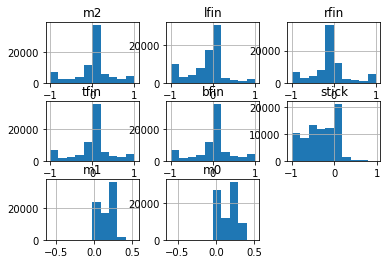

In [34]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_act.hist()

array([[<AxesSubplot:title={'center':'orientation.x'}>,
        <AxesSubplot:title={'center':'orientation.y'}>,
        <AxesSubplot:title={'center':'orientation.z'}>,
        <AxesSubplot:title={'center':'orientation.w'}>],
       [<AxesSubplot:title={'center':'angVelocity.x'}>,
        <AxesSubplot:title={'center':'angVelocity.y'}>,
        <AxesSubplot:title={'center':'angVelocity.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>],
       [<AxesSubplot:title={'center':'velocity.linear.y'}>,
        <AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'linear_acceleration.x'}>,
        <AxesSubplot:title={'center':'linear_acceleration.y'}>],
       [<AxesSubplot:title={'center':'linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>]], dtype=object)

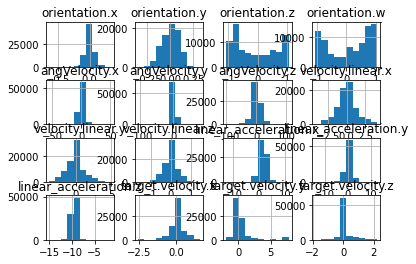

In [35]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.hist()

### Define Reward Function

In [36]:
class Define_rewardFn():
    def __init__(self):
        pass
 
    def reward_fn(self, next_obs_df, prev_act_list, prev_obs_list,
                  obs_reward_weights=(1,1), reward_weights=(1,0,1,1),
                  **params):
        
        next_obsCost_np = 0
        next_obsCost_np = self.calculate_obsCost(next_obs_df, obs_reward_weights, **params)

        prev_obsCost_np = 0
        for obs_df in prev_obs_list:
            obsCost_np = self.calculate_obsCost(obs_df, obs_reward_weights, **params)
            prev_obsCost_np += obsCost_np
        
        prev_actCost_np = 0
        for act_df in prev_act_list:
            actCost_np = self.calculate_actCost(act_df, actCost_feature_list)
            prev_actCost_np += actCost_np
        
        prev_actChangeCost_np = 0
        for i in range(len(prev_act_list)-1):
            act_df, next_act_df = prev_act_list[i], prev_act_list[i+1]
            actChangeCost_np = self.calculate_actChangeCost(act_df, next_act_df, actChangeCost_feature_list)
            prev_actChangeCost_np += actChangeCost_np

        rewards = reward_weights[0]*next_obsCost_np \
                    + reward_weights[1]*prev_obsCost_np \
                    + reward_weights[2]*prev_actCost_np \
                    + reward_weights[3]*prev_actChangeCost_np
        
        rewards = pd.DataFrame({'rewards':rewards})
        info = pd.DataFrame({'next_obsCost':next_obsCost_np, 'prev_obsCost':prev_obsCost_np, 
                             'prev_actCost':prev_actCost_np, 'prev_actChangeCost':prev_actChangeCost_np})
        return rewards, info
    
    def calculate_obsCost(self, obs_df, obs_reward_weights, **params):
        xy_target_df = obs_df[ xy_target_feature_list ]
        xy_cost_df = obs_df[ xy_cost_feature_list ]
        z_target_df = obs_df[ z_target_feature_list ]
        z_cost_df = obs_df[ z_cost_feature_list ]
        xyCost_np = obs_reward_weights[0]*self.calculate_xyCost(xy_cost_df, xy_target_df)
        zCost_np = obs_reward_weights[1]*self.calculate_zCost(z_cost_df, z_target_df)
        obs_cost_np = xyCost_np + zCost_np
        return obs_cost_np
    
    def calculate_xyCost(self, xy_df, xy_target_df):
        xyCost_np = xy_target_df.to_numpy()  - xy_df.to_numpy() 
        xyCost_np = -np.linalg.norm(xyCost_np, axis=1)
        return xyCost_np
    
    def calculate_zCost(self, z_df, z_target_df):
        zCost_np = z_target_df.to_numpy()  - z_df.to_numpy() 
        zCost_np = -np.abs(zCost_np).reshape(zCost_np.shape[0],)
        return zCost_np

    def calculate_actCost(self, act_df, actCost_feature_list):
        actCost_np = act_df[ actCost_feature_list ].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1) 
        return actCost_np
    
    def calculate_actChangeCost(self, act_df, next_act_df, actChangeCost_feature_list):
        actChangeCost_np = next_act_df[ actChangeCost_feature_list ].to_numpy() - act_df[ actChangeCost_feature_list ].to_numpy()
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1) 
        return actChangeCost_np
    
    def split_xy(self, prev_act_list, prev_obs_list, next_obs, rewards):
        x_df_list = []
        for obs_df, act_df in zip(prev_obs_list, prev_act_list):
            obs_act_df = pd.concat([obs_df, act_df], axis=1)
            x_df_list.append(obs_act_df)
        x = pd.concat(x_df_list, axis=1)
        y = pd.concat([rewards, next_obs], axis=1)
        return x, y
        
    def main(self, objTrans, **params):
        prev_act_list, prev_obs_list = objTrans.get_prev_transitions_list()
        next_act, next_obs = objTrans.get_next_transitions()
                
        rewards, info = self.reward_fn(next_obs, prev_act_list, prev_obs_list, **params)
        x, y = self.split_xy(prev_act_list, prev_obs_list, next_obs, rewards)
        
        return x, y, rewards, info


In [37]:
clsDefineRewardFn = Define_rewardFn()
x_train, y_train, rewards_train, info_train = clsDefineRewardFn.main(objTrans_train, **params)
x_test, y_test, rewards_test, info_test = clsDefineRewardFn.main(objTrans_test, **params)

array([[<AxesSubplot:title={'center':'next_obsCost'}>,
        <AxesSubplot:title={'center':'prev_obsCost'}>],
       [<AxesSubplot:title={'center':'prev_actCost'}>,
        <AxesSubplot:title={'center':'prev_actChangeCost'}>]],
      dtype=object)

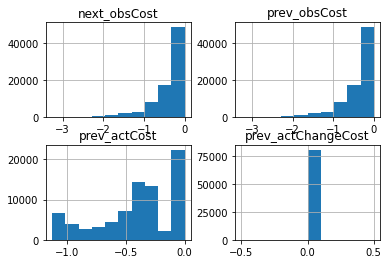

In [38]:
info_train.hist()

array([[<AxesSubplot:title={'center':'rewards'}>]], dtype=object)

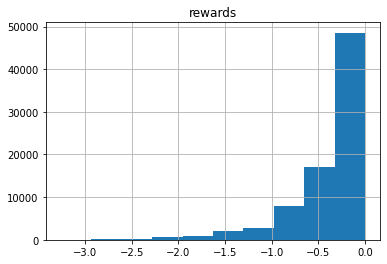

In [39]:
rewards_train.hist()

### Save data to csv

In [40]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.to_csv(os.path.join(RealResults_path,'obs'), index=False)
cur_act.to_csv(os.path.join(RealResults_path,'act'), index=False)
x_train.to_csv(os.path.join(RealResults_path,'x_train'), index=False)
y_train.to_csv(os.path.join(RealResults_path,'y_train'), index=False)
x_test.to_csv(os.path.join(RealResults_path,'x_test'), index=False)
y_test.to_csv(os.path.join(RealResults_path,'y_test'), index=False)

In [41]:
act_read_test = pd.read_csv(os.path.join(RealResults_path,'act'))
obs_read_test = pd.read_csv(os.path.join(RealResults_path,'obs'))
x_train_read_test = pd.read_csv(os.path.join(RealResults_path,'x_train'))
y_train_read_test = pd.read_csv(os.path.join(RealResults_path,'y_train'))

array([[<AxesSubplot:title={'center':'orientation.x'}>,
        <AxesSubplot:title={'center':'orientation.y'}>,
        <AxesSubplot:title={'center':'orientation.z'}>,
        <AxesSubplot:title={'center':'orientation.w'}>],
       [<AxesSubplot:title={'center':'angVelocity.x'}>,
        <AxesSubplot:title={'center':'angVelocity.y'}>,
        <AxesSubplot:title={'center':'angVelocity.z'}>,
        <AxesSubplot:title={'center':'velocity.linear.x'}>],
       [<AxesSubplot:title={'center':'velocity.linear.y'}>,
        <AxesSubplot:title={'center':'velocity.linear.z'}>,
        <AxesSubplot:title={'center':'linear_acceleration.x'}>,
        <AxesSubplot:title={'center':'linear_acceleration.y'}>],
       [<AxesSubplot:title={'center':'linear_acceleration.z'}>,
        <AxesSubplot:title={'center':'target.velocity.x'}>,
        <AxesSubplot:title={'center':'target.velocity.y'}>,
        <AxesSubplot:title={'center':'target.velocity.z'}>]], dtype=object)

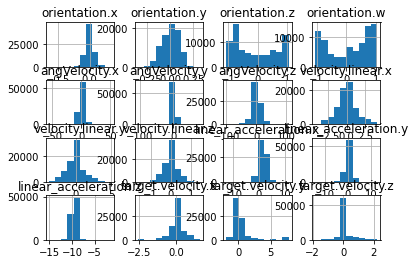

In [42]:
obs_read_test.hist()

In [43]:
act_read_test

,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.346000,0.000000,0.000000,0.346000,0.346000,-0.040000,0.224000,0.224000
1,0.372000,0.000000,0.000000,0.372000,0.372000,-0.036000,0.232000,0.232000
2,0.442000,0.000000,0.000000,0.442000,0.442000,-0.036000,0.246000,0.246000
3,0.500000,0.000000,0.000000,0.500000,0.500000,-0.040000,0.260000,0.260000
4,0.530000,0.000000,0.000000,0.530000,0.530000,-0.036000,0.256000,0.256000
...,...,...,...,...,...,...,...,...
80361,0.014320,-0.459337,-0.454241,0.016076,0.024715,-0.822623,0.290958,0.271392
80362,-0.792495,-0.076638,-0.046882,-0.835725,-0.806181,-0.228864,-0.002130,0.040600
80363,0.477381,-0.167209,-0.225745,0.493111,0.482280,-0.637657,0.377142,0.364195
80364,0.627096,0.002583,0.023373,0.562000,0.597742,-0.652511,0.040889,0.061862


In [44]:
y_train_read_test[y_train_read_test['target.velocity.x']==0].count()

rewards                  13148
orientation.x            13148
orientation.y            13148
orientation.z            13148
orientation.w            13148
angVelocity.x            13148
angVelocity.y            13148
angVelocity.z            13148
velocity.linear.x        13148
velocity.linear.y        13148
velocity.linear.z        13148
linear_acceleration.x    13148
linear_acceleration.y    13148
linear_acceleration.z    13148
target.velocity.x        13148
target.velocity.y        13148
target.velocity.z        13148
dtype: int64

In [45]:
x_train_read_test

,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,...,target.velocity.y,target.velocity.z,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.022583,0.059098,0.175441,0.982455,6.416730,-2.495774,-1.012899,0.861034,0.017769,-0.086961,...,0.000000,0.000000,0.346000,0.000000,0.000000,0.346000,0.346000,-0.040000,0.224000,0.224000
1,0.024767,0.057734,0.170457,0.983360,2.591935,-3.543970,-13.902404,0.853818,0.008835,-0.066604,...,0.000000,0.000000,0.372000,0.000000,0.000000,0.372000,0.372000,-0.036000,0.232000,0.232000
2,0.028555,0.056422,0.165418,0.984194,2.052119,-2.743255,-11.181817,0.874612,-0.054235,-0.047649,...,0.000000,0.000000,0.442000,0.000000,0.000000,0.442000,0.442000,-0.036000,0.246000,0.246000
3,0.029745,0.055752,0.161460,0.984854,4.683132,-0.735427,6.289881,0.897282,-0.091351,-0.025907,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.500000,-0.040000,0.260000,0.260000
4,0.031738,0.054446,0.155271,0.985860,2.447562,-0.271320,0.306804,0.897198,-0.146089,-0.010188,...,0.000000,0.000000,0.530000,0.000000,0.000000,0.530000,0.530000,-0.036000,0.256000,0.256000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80361,-0.069617,0.109328,0.794002,0.598270,0.377081,-2.695616,6.921923,1.264622,1.332096,-0.306458,...,-0.000353,0.005413,0.014320,-0.459337,-0.454241,0.016076,0.024715,-0.822623,0.290958,0.271392
80362,0.032682,0.008950,0.862210,0.393324,-1.701011,2.873294,13.420953,0.085865,3.117748,0.536267,...,-0.319656,0.261434,-0.792495,-0.076638,-0.046882,-0.835725,-0.806181,-0.228864,-0.002130,0.040600
80363,-0.009528,-0.005290,0.985803,-0.292112,-2.086832,-3.446179,10.151603,-1.841359,2.096248,0.520569,...,-0.157587,0.118352,0.477381,-0.167209,-0.225745,0.493111,0.482280,-0.637657,0.377142,0.364195
80364,0.008098,-0.015454,0.898349,-0.488930,-10.103483,-20.460791,-48.344696,-1.741656,0.451184,0.176493,...,-0.158517,0.283394,0.627096,0.002583,0.023373,0.562000,0.597742,-0.652511,0.040889,0.061862


In [46]:
y_train_read_test

,rewards,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-0.066604,0.024767,0.057734,0.170457,0.983360,2.591935,-3.543970,-13.902404,0.853818,0.008835,-0.066604,0.883501,-0.648477,-9.461720,0.000000,0.000000,0.000000
1,-0.047649,0.028555,0.056422,0.165418,0.984194,2.052119,-2.743255,-11.181817,0.874612,-0.054235,-0.047649,1.095721,-1.099764,-9.494010,0.000000,0.000000,0.000000
2,-0.025907,0.029745,0.055752,0.161460,0.984854,4.683132,-0.735427,6.289881,0.897282,-0.091351,-0.025907,0.632375,-0.628288,-9.394749,0.000000,0.000000,0.000000
3,-0.010188,0.031738,0.054446,0.155271,0.985860,2.447562,-0.271320,0.306804,0.897198,-0.146089,-0.010188,0.663815,-0.880058,-9.365648,0.000000,0.000000,0.000000
4,-0.012432,0.031344,0.054227,0.151469,0.986476,1.117321,-0.099008,-3.358958,0.906896,-0.156349,0.012432,0.842237,-1.355096,-9.544238,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80361,-0.274833,0.032682,0.008950,0.862210,0.393324,-1.701011,2.873294,13.420953,0.085865,3.117748,0.536267,-1.305720,-0.020948,-10.089717,-1.098145,-0.319656,0.261434
80362,-0.402217,-0.009528,-0.005290,0.985803,-0.292112,-2.086832,-3.446179,10.151603,-1.841359,2.096248,0.520569,0.793770,-0.757124,-9.585815,-1.006921,-0.157587,0.118352
80363,-0.106901,0.008098,-0.015454,0.898349,-0.488930,-10.103483,-20.460791,-48.344696,-1.741656,0.451184,0.176493,-0.002370,0.117794,-8.993156,-0.988540,-0.158517,0.283394
80364,-0.332964,0.061855,-0.002441,0.905053,-0.533811,-0.219916,0.115938,4.048441,-1.290007,0.836496,0.591083,-1.237839,-0.352683,-9.598909,-0.955490,-0.422807,0.258120


In [52]:
objTrans_train.get_time()[27]

1607428192.9500918